In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import Xception
from tensorflow import keras
import tensorflow as tf
import os
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np

In [2]:
X = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

for layer in X.layers:
    layer.trainable = False

In [3]:
x = Flatten()(X.output)
X_out = Dense(2, activation='softmax')(x)

In [4]:
from keras.models import Model
model = Model(inputs=X.input, outputs=X_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [5]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.02),
    metrics=['accuracy'],
)

In [6]:
# Collecting Train Data

DATA_PATH = "../../my-datasets/Hurricane_Damage/train_another/"
CATEGORIES = ["damage", "no_damage"]

train_data_list = []

for category in CATEGORIES:
    dir_path = os.path.join(DATA_PATH, category)
    img_list = os.listdir(dir_path)
    class_num = CATEGORIES.index(category)
    print(f"Collecting from train_another/{category}/")
    for img_path in tqdm(img_list):
        if img_path.startswith(".ipynb_checkpoints", 0, len(img_path)):
            continue
        img = Image.open(os.path.join(dir_path, img_path))
        img_arr = np.array(img, dtype=int)
        if img_arr.shape[-1] == 4:
            img_arr = img_arr[...,:3]
        if img_arr.shape != (128, 128, 3):
            continue
        train_data_list.append([img_arr, class_num])
        
print(f"Total number of samples is {len(train_data_list)}")

100%|██████████| 5000/5000 [00:05<00:00, 929.13it/s]


100%|██████████| 5001/5001 [00:05<00:00, 910.71it/s]

Total number of samples is 10000


In [7]:
import random
random.shuffle(train_data_list)

X_train = []
y_train = []

for image, label in train_data_list:
    X_train.append(image)
    y_train.append(label)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape)
print(y_train.shape)

### Converting y into a one-hot vector ###
shape = (y_train.size, y_train.max()+1)
y_train_one_hot = np.zeros(shape)
rows = np.arange(y_train.size)
y_train_one_hot[rows, y_train] = 1

print(y_train_one_hot.shape)

(10000, 128, 128, 3)
(10000,)
(10000, 2)


In [8]:
# Collecting Test Data

DATA_PATH = "../../my-datasets/Hurricane_Damage/test/"
CATEGORIES = ["damage", "no_damage"]

test_data_list = []

for category in CATEGORIES:
    dir_path = os.path.join(DATA_PATH, category)
    img_list = os.listdir(dir_path)
    class_num = CATEGORIES.index(category)
    print(f"Collecting from test/{category}/")
    for img_path in tqdm(img_list):
        img = Image.open(os.path.join(dir_path, img_path))
        img_arr = np.array(img)
        test_data_list.append([img_arr, class_num])
        
print(f"Total number of samples is {len(test_data_list)}")

100%|██████████| 1000/1000 [00:00<00:00, 1089.10it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1078.94it/s]

Total number of samples is 2000


In [9]:
import random
random.Random(30).shuffle(test_data_list)

X_test = []
y_test = []

for image, label in test_data_list:
    X_test.append(image)
    y_test.append(label)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(X_test.shape)
print(y_test.size)

### Converting y_test into a one-hot vector ###
shape = (y_test.size, y_test.max()+1)
y_test_one_hot = np.zeros(shape)
rows = np.arange(y_test.size)
y_test_one_hot[rows, y_test] = 1

(2000, 128, 128, 3)
2000


In [10]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "../models/Xception_model/Xception_damage_classification.ckpt"
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True
    ),
]

# This line below must be commented when running this cell for the first time
# model.load_weights(checkpoint_path)

model_history = model.fit(
    x=X_train,
    y=y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    batch_size=16,
    epochs=15,
    verbose=1,
    callbacks=callbacks_list
) 

2022-02-07 05:53:36.434305: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-02-07 05:53:40.302798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


Epoch 1/15
625/625 [==============================] - 25s 29ms/step - loss: 161.7211 - accuracy: 0.7734 - val_loss: 97.5246 - val_accuracy: 0.8450
Epoch 2/15
625/625 [==============================] - 17s 27ms/step - loss: 140.0338 - accuracy: 0.8165 - val_loss: 103.1470 - val_accuracy: 0.8290
Epoch 3/15
625/625 [==============================] - 17s 27ms/step - loss: 125.1352 - accuracy: 0.8353 - val_loss: 187.1640 - val_accuracy: 0.7805
Epoch 4/15
625/625 [==============================] - 17s 27ms/step - loss: 108.9591 - accuracy: 0.8497 - val_loss: 116.9290 - val_accuracy: 0.8610
Epoch 5/15
625/625 [==============================] - 17s 28ms/step - loss: 90.1583 - accuracy: 0.8680 - val_loss: 164.4265 - val_accuracy: 0.8010
Epoch 6/15
625/625 [==============================] - 17s 28ms/step - loss: 135.5796 - accuracy: 0.8494 - val_loss: 222.1902 - val_accuracy: 0.8460
Epoch 7/15
625/625 [==============================] - 17s 28ms/step - loss: 92.7643 - accuracy: 0.8733 - val_loss:

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

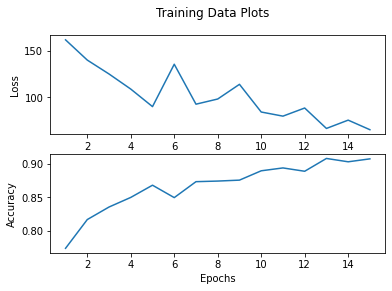

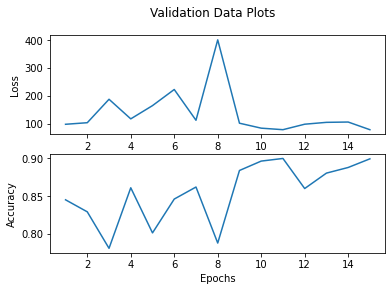

In [19]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.array(model_history.history['loss'])

val_loss = np.array(model_history.history['val_loss'])

train_acc = np.array(model_history.history['accuracy'])

val_acc = np.array(model_history.history['val_accuracy'])

epochs = np.arange(1, train_acc.size+1)

fig, plots = plt.subplots(2)
fig.suptitle('Training Data Plots')
plots[0].plot(epochs, train_loss)
plots[1].plot(epochs, train_acc)
plots[0].set(ylabel="Loss")
plots[1].set(ylabel="Accuracy", xlabel="Epochs")

fig, plots = plt.subplots(2)
fig.suptitle('Validation Data Plots')
plots[0].plot(epochs, val_loss)
plots[1].plot(epochs, val_acc)
plots[0].set(ylabel="Loss")
plots[1].set(ylabel="Accuracy", xlabel="Epochs")

In [ ]:
checkpoint_path = "../models/Xception_model/Xception_damage_classification.ckpt"

X = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = Flatten()(X.output)
X_out = Dense(2, activation='softmax')(x)
new_model = Model(inputs=X.input, outputs=X_out)

new_model.load_weights(checkpoint_path)

In [ ]:
path = "../../my-datasets/Hurricane_Damage/test/damage/-93.65936500000001_30.138793.jpeg"
test_img = Image.open(path)
test_arr = np.asarray(test_img)
test_arr = np.expand_dims(test_arr, axis=0) 
pred = new_model.predict(x=test_arr)
print(pred)
test_img

In [ ]:
pred_ = np.argmax(pred, axis=1)
if(pred_ == 0):
    print("Hello")